In [1]:
use_gpu = False

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')

# if use_gpu:
#     from utils.gpu_tools import *
#     os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([ str(obj) for obj in select_gpu(query_gpu())])

# os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

## load data

In [11]:
year_list = np.arange(2001,2020,1)

In [12]:
images = []
label_df = []
for year in [2001]:
    images.append(np.memmap(os.path.join("./img_data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("./img_data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

(91985, 64, 60)
(91985, 8)


## build dataset

In [13]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]
    
dataset = MyDataset(images, (label_df.Ret_5d > 0).values)
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

In [14]:
test_dataloader

# the neural network

In [15]:
net_path = './CNN/models/baseline_epoch_3_train_0.72169_val_0.27944/model.pt'

In [16]:
device = 'cpu'

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5, 3), stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.reshape(-1, 1, 64, 60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1, 46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x
    



## test

In [33]:
net = Net()

target = []
predict = []

def eval_loop(dataloader, net, loss_fn):
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                
                y = [[0, 1] if i == 1 else [1, 0] for i in y]
                y = torch.tensor(y)
                y = y.to(torch.float32)
                    
                y = y.to(device)
                
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y)
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)

In [34]:
loss_fn = nn.BCELoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:,1]).cpu().numpy()

 36%|███████████████████████                                          | 16/45 [05:00<09:04, 18.76s/it, running_loss=0.912]


KeyboardInterrupt: 

## Plot the performance

In [289]:
from matplotlib import pyplot as plt

### Same Weighted

In [315]:
threshold = 0.

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_baseline = label_filtered .groupby(['Date'])['Ret_20d'].mean()

threshold = 0.58

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_cnn = label_filtered .groupby(['Date'])['Ret_20d'].mean()


#### number of stocks selected by time

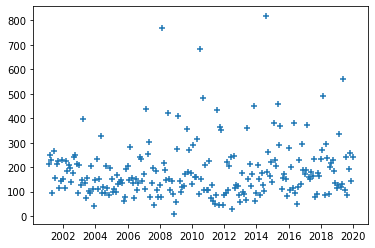

In [316]:
plt.scatter(label_filtered.groupby(['Date'])['ret'].count().index, label_filtered.groupby(['Date'])['ret'].count(),marker='+')

### Compare of log accumulate return

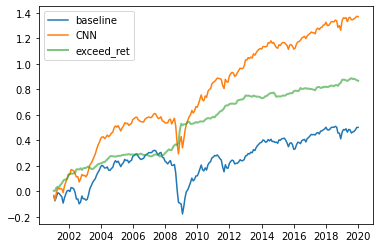

In [328]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
fig = plt.figure()
plt.plot(log_ret_baseline, label='baseline')
plt.plot(log_ret_cnn, label='CNN')
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2, label='exceed_ret')
plt.legend()
plt.show()
fig.savefig('../pic/performance1.png',dpi=300)


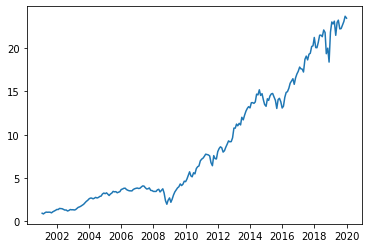

In [329]:
plt.plot((ret_cnn+1).cumprod().fillna(method='ffill'), label='CNN_accumulate_ret')
plt.savefig('../pic/performance2.png',dpi=300)

## Weighted by EWMA_Vol

In [313]:
label_df['weighted_ret'] = 1 * label_df.Ret_20d * label_df['EWMA_vol']
label_df['weight'] = 1 * label_df['EWMA_vol']
ret_baseline = label_df.groupby(['Date'])['weighted_ret'].sum()/(label_df.groupby(['Date'])['weight'].sum())

threshold = 0.58

label_df['weighted_ret'] = (predict_logit>threshold) * label_df.Ret_20d * label_df['EWMA_vol']
label_df['weight'] = (predict_logit>threshold) * label_df['EWMA_vol']
ret_cnn = label_df.groupby(['Date'])['weighted_ret'].sum()/(label_df.groupby(['Date'])['weight'].sum())

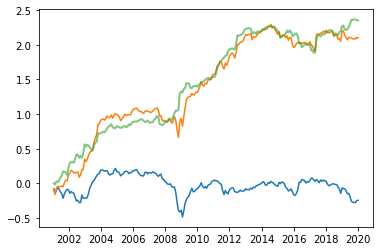

In [314]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
plt.plot(log_ret_baseline)
plt.plot(log_ret_cnn)
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2)

In [3]:
from torch import nn
import torch
m= nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, 2, requires_grad=True)
target = torch.rand(3, 2, requires_grad=False)
output = loss(m(input), target)
output.backward()

In [4]:
output

tensor(0.7134, grad_fn=<BinaryCrossEntropyBackward0>)

In [5]:
input

tensor([[ 0.9737, -1.0491],
        [ 0.1638, -1.0289],
        [-2.8300,  0.3430]], requires_grad=True)

In [7]:
target

tensor([[0.8431, 0.2182],
        [0.3905, 0.7493],
        [0.2416, 0.3893]])

In [21]:
y = [0,1,1,0]

In [29]:
result = [[0, 1] if i == 1 else [1, 0] for i in y]


In [30]:
result

[[1, 0], [0, 1], [0, 1], [1, 0]]